# Elekta MEG Example (Sensor Level)

Start-to-end example script for applying the canonical HMM to Elekta MEG data.

#### Input Data

We will use data in BIDS format:
```
BIDS/
├── ...
├── sub-01/
│   ├── meg/
│   │   ├── sub-01_task-resteyesclosed_meg.fif
│   │   ├── ...
│   ├── anat/
│   │   ├── sub-01_T1w.nii.gz
│   │   └── ...
├── ...
```
And write output to the `BIDS/derivatives` directory.

#### Steps

1. Preprocessing:
    - We clean the sensor-level MEG data and save the output to `BIDS/derivatives/preprocessed`.

2. Prepare Data for the Canonical HMM:
    - We will perform PCA, time-delay embedding, a 2nd PCA, and standardisation to prepare the parcel data for the canonical HMM.

3. Fit the Canonical HMM:
    - We will apply the canonical HMM to the prepared data.

4. HMM Post-Hoc Analysis:
    - Estimate state-specific quantities of interest, such as spectral properties and summary statistics for dynamics.
    - The output will be saved to `BIDS/derivatives/hmm`.

 Although we provide a single start-to-end example script, it is possible to separate the different steps. E.g. you may wish to do all the preprocessing (for different sessions) in a script then have a separate script for the HMM.

#### Import Packages

In [1]:

import numpy as np
from pathlib import Path

import mne
mne.viz.set_3d_backend("notebook")

from modules import preproc, hmm

from osl_dynamics import inference, analysis
from osl_dynamics.data import Data
from osl_dynamics.utils import plotting

Using notebook 3d backend.


2025-11-14 15:43:13.344576: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Session Info

Let's specify which session in the `BIDS` directory we wish to study.

In [2]:
subject = "01"
task = "resteyesclosed"
id = f"sub-{subject}_task-{task}"
print("id:", id)

id: sub-01_task-resteyesclosed


## 1. Preprocessing

First we want to clean the sensor data. We will use MNE to do this. Let's load the raw sensor data.

In [3]:
raw_file = f"BIDS/sub-{subject}/meg/{id}_meg.fif"
raw = mne.io.read_raw_fif(raw_file, preload=True)

Opening raw data file BIDS/sub-01/meg/sub-01_task-resteyesclosed_meg.fif...
    Read a total of 8 projection items:
        grad3vect.fif : PCA-v1 (1 x 306)  idle
        grad3vect.fif : PCA-v2 (1 x 306)  idle
        grad3vect.fif : PCA-v3 (1 x 306)  idle
        mag5vect.fif : PCA-v1 (1 x 306)  idle
        mag5vect.fif : PCA-v2 (1 x 306)  idle
        mag5vect.fif : PCA-v3 (1 x 306)  idle
        mag5vect.fif : PCA-v4 (1 x 306)  idle
        mag5vect.fif : PCA-v5 (1 x 306)  idle
    Range : 28000 ... 327999 =     28.000 ...   327.999 secs
Ready.
Reading 0 ... 299999  =      0.000 ...   299.999 secs...


Now, let's perform some minimal preprocessing: filtering, downsampling and bad segment detection.

In [4]:
raw = raw.filter(l_freq=0.5, h_freq=45, method="iir", iir_params={"order": 5, "ftype": "butter"})
raw = raw.resample(sfreq=250)
raw = preproc.detect_bad_segments(raw, picks="mag")
raw = preproc.detect_bad_segments(raw, picks="mag", mode="diff")
raw = preproc.detect_bad_segments(raw, picks="grad")
raw = preproc.detect_bad_segments(raw, picks="grad", mode="diff")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 0.50, 45.00 Hz: -6.02, -6.02 dB

Finding events on: STI101
Trigger channel STI101 has a non-zero initial value of 4 (consider using initial_event=True to detect this event)
Finding events on: STI101
Trigger channel STI101 has a non-zero initial value of 4 (consider using initial_event=True to detect this event)

Bad segment detection
---------------------
Modality: mag
Mode: None
Metric: std
Significance level: 0.05
Maximum fraction: 0.1
Found 2 bad segments: 0.8/300.0 seconds rejected (0.3%)

Bad segment detection
---------------------
Omitting 204 of 75000 (0.27%) samples, retaining 74796 (99.73%) samples.
Modality: mag
Mode: diff
Metric: std
Significance level: 0.05
Maximum fraction: 0.1
Found 0 bad segmen

And finally we save the preprocessed data.

In [5]:
preproc_file = Path(f"BIDS/derivatives/preprocessed/{id}_preproc-raw.fif")
preproc_file.parent.mkdir(parents=True, exist_ok=True)
raw.save(preproc_file, overwrite=True)

Overwriting existing file.
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-01_task-resteyesclosed_preproc-raw.fif
Overwriting existing file.
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-01_task-resteyesclosed_preproc-raw.fif
[done]


[PosixPath('/Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-01_task-resteyesclosed_preproc-raw.fif')]

## 2. Prepare Data for the Canonical HMM

In [6]:
# Load and prepare the data
data = Data(str(preproc_file), picks="meg", reject_by_annotation="omit")
data = hmm.prepare_data_for_canonical_hmm(data, parcellation="Elekta")

# Save
hmm_dir = f"BIDS/derivatives/hmm/{id}"
data.save(hmm_dir)

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

PCA:   0%|          | 0/1 [00:00<?, ?it/s]

TDE-PCA:   0%|          | 0/1 [00:00<?, ?it/s]

Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

Saving data:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Fit the Canonical HMM

First, we load a canonical HMM.

In [7]:
model = hmm.load_canonical_hmm(n_states=8, parcellation="Elekta")
model.summary()

Model: "HMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 400, 160)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means               │ (8, 160)          │      1,280 │ data[0][0]        │
│ (VectorsLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covs                │ (8, 160, 160)     │    103,040 │ data[0][0]        │
│ (CovarianceMatrice… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll                  │ (None, 400, 160)  │          0 │ data[0][0],       │
│ (SeparateLogLikeli… │                   │            │ means[0][0],      │
│                     │                   │            │ covs[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hid_state_inf       │ [(None, 400,      │         72 │ ll[0][0]          │
│ (HiddenMarkovState… │ 160), (None, 400, │            │                   │
│                     │ 8, 8)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll_loss             │ (1)               │          0 │ ll[0][0],         │
│ (SumLogLikelihoodL… │                   │            │ hid_state_inf[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 104,392 (407.78 KB)

 Trainable params: 103,112 (402.78 KB)

 Non-trainable params: 1,280 (5.00 KB)

Now let's infer the probability of each state being active at a given time point in the new data.

2025-11-14 15:43:52 INFO osl-dynamics [inf_mod_base.py:1133:get_alpha]: Getting alpha


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 934ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step  


2025-11-14 15:44:05.881967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Overwriting existing file.
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/hmm/sub-01_task-resteyesclosed/alp_raw.fif
Overwriting existing file.
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/hmm/sub-01_task-resteyesclosed/alp_raw.fif
[done]


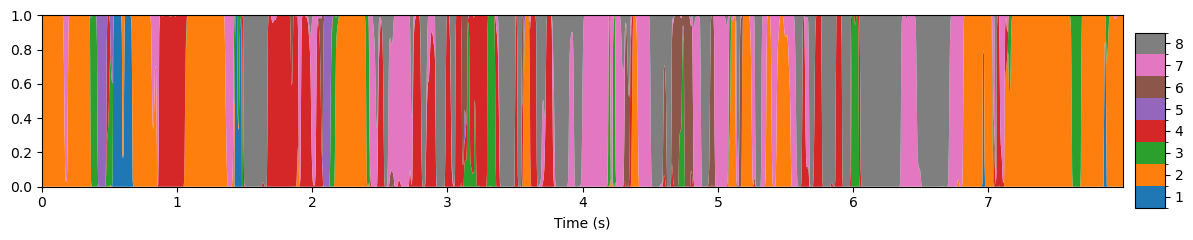

In [ ]:
# State probability time course
alp = model.get_alpha(data)

# Save
alp_raw = inference.modes.convert_to_mne_raw(alp, str(preproc_file), n_embeddings=data.n_embeddings)
alp_raw.save(f"{hmm_dir}/alp_raw.fif", overwrite=True)

# Plot (just the first 8 seconds for visualisation)
fig, ax = plotting.plot_alpha(alp, n_samples=2000, sampling_frequency=250)

## 4. HMM Post-Hoc Analysis

Now we have the state probabilities, we can perform 'post-hoc analysis' where we estimate state-specific quantities of interest such as spectral properties, networks, and summary statistics for dynamics.

See the [osl-dynamics docs](https://osl-dynamics.readthedocs.io/en/latest/documentation.html) for further information and tutorials, as well as code for visualisations.

Let's start with the spectral properties.

In [9]:
# Calculate multitaper
trimmed_data = data.trim_time_series(sequence_length=model.config.sequence_length, prepared=False)
f, psd = analysis.spectral.multitaper_spectra(
    data=trimmed_data,
    alpha=alp,
    sampling_frequency=250,
    frequency_range=[0.5, 45],
    calc_coh=False,
)
print(f.shape)
print(psd.shape)

# Save
np.save(f"{hmm_dir}/f.npy", f)
np.save(f"{hmm_dir}/psd.npy", psd)

2025-11-14 15:44:07 INFO osl-dynamics [spectral.py:458:multitaper_spectra]: Calculating spectra


(90,)
(8, 306, 90)


Now let's use the spectra to calculate state-specific power maps.

In [10]:
pow_maps = analysis.power.variance_from_spectra(f, psd)
print(pow_maps.shape)
np.save(f"{hmm_dir}/pow_maps.npy", pow_maps)

(8, 306)


Finally, let's calculate summary statistics for dynamics.

In [ ]:
# Binarise the state probabilities
stc = inference.modes.argmax_time_courses(alp)

# Summary statistics
fo = analysis.post_hoc.fractional_occupancies(stc)
lt = analysis.post_hoc.mean_lifetimes(stc, sampling_frequency=250)
intv = analysis.post_hoc.mean_intervals(stc, sampling_frequency=250)
sr = analysis.post_hoc.switching_rates(stc, sampling_frequency=250)

# Save
np.save(f"{hmm_dir}/fo.npy", fo)
np.save(f"{hmm_dir}/lt.npy", lt)
np.save(f"{hmm_dir}/intv.npy", intv)
np.save(f"{hmm_dir}/sr.npy", sr)